## Regressing HF ship parameters with shipyard data

1. Get realistic fuel consumption rates `fr = C * [ sum(eng) + a * # Gen + b * # small gens ]`
2. Use that to figure out combat time from fuel/fuel rates `ct = C * fr`
3. Get realistic mappings from T/W to Speed `spd = C * (sum(thrust)/sum(wt))` 
4. Use Speed and Combat Time to map range `range = C * spd * combat time`
5. That's it! Need 4 values of C, + a and b above. 6 parameters to solve!

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [80]:
data = pd.read_csv('ships-data.csv',na_values='0')
dataf = data.fillna(value=0,inplace=False)

Data should have `twr, spd, range, consumption, wt, thr, ct, fuel, fr, gen_b, gen_s` from the shipyard. 

* `twr` = thrust-weight ratio (copy in) (used to verify equation 3, above)
* `spd` = reported speed (used to verify equation 3, above)
* `range` = reported range (used to verify equation 4)
* `consumption` = reported fuel / 1000 km. Not currently used
* `wt` = reported weight. used to calculate most of the equations. Will be used to verify weight of components later.
* `thr` = reported thrust (the MN value), used to calculate most of the stats above
* `ct` = combat time, used to verify our combat time calculations
* `fuel` = the fuel capacity (by counting tanks). 
* `fr` = fuel rate, the amount of fuel used by engines (by summing up the reported values)
* `gen_b` = the number of "big" generators
* `gen_s` = the number of "small" generators

In [81]:
data.columns

Index(['twr', 'spd', 'range', 'consumption', 'wt', 'thr', 'ct', 'fuel', 'fr',
       'ft_eng', 'fr_gen', 'ft_both', 'ct_calc', 'spdxct', 'gen_b', 'gen_s',
       'ct_pred', 'diff', 'diffpgen', 'diffpsgen'],
      dtype='object')

In [123]:
# Helpful functions
from sklearn.linear_model import LinearRegression
def trendline(df,x,y):
    xn = x
    yn = y
    x = df[x].values.reshape(-1,1)
    y = df[y].values.reshape(-1,1)
    lr = LinearRegression()
    Y=lr.fit(x,y).predict(x)
    plt.plot(x,Y,'r-')
    plt.plot(x,y,'b.')
    plt.title("{} -> {}\n y={}x+{};\n R={}".format(xn,yn, lr.coef_[0][0],lr.intercept_[0], lr.score(x,y)))
    return lr.coef_, lr.intercept_, lr.score(x,y)

def qfit(x,y) :
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    lr = LinearRegression()
    Y=lr.fit(x,y).predict(x)
    return lr.score(x,y)

Speed = 90.10984733082836* reported TWR - 2.33416268914425


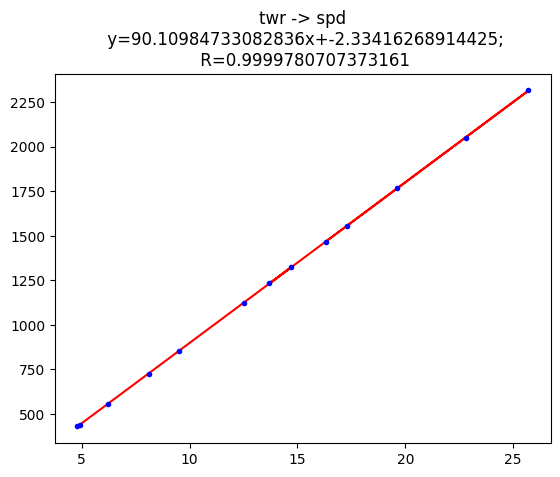

In [150]:
#TWR->SPD
x_dat = data["twr"].values
y_dat = data["spd"].values
m, b, r = trendline(data,'twr','spd')
print(f"Speed = {m[0][0]}* reported TWR - {-b[0]}")


Speed = 9152.354477684103* sum(T)/sum(W) - 0.2587983672608516


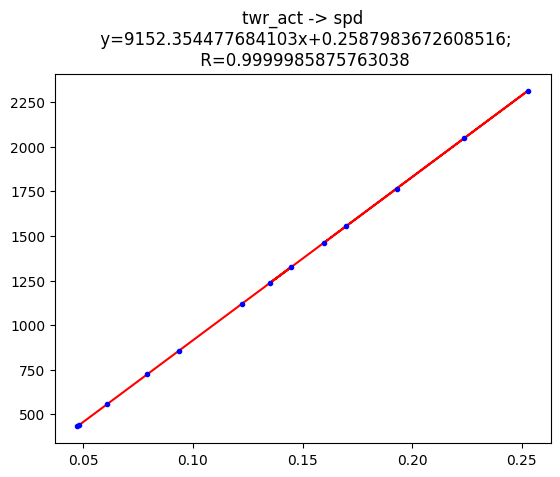

In [151]:
# actual thrust / actual wt --> TWR
data['twr_act']=data['thr']/data['wt']
m,b,R = trendline(data,'twr_act','spd')
print(f"Speed = {m[0][0]}* sum(T)/sum(W) - {b[0]}")

SPD_TWR_C = m[0][0]
SPD_TWR_B = b[0]

In [115]:
## Let's just brute force it. Try various scalars for gen_b and gen_s.
# Suppose ct = C* [fuel / (fr + a*gen_b + b*gen_s)]
import numpy as np
A = np.arange(.01,1,.01)
B = np.arange(.01,1,.01)
bestr = 0
best = (0,0)
for a in A:
    for b in B:
        fr = dataf['fr']+a*dataf['gen_b']+b*dataf['gen_s']
        cft = dataf['fuel']/fr
        sc = qfit(data['ct'].values, cft.values)
        if (sc>bestr):
            bestr = sc
            best = (a,b)

print(f"Generators take {best} fuel (l,s)")

Both generators use .1 kg/s
Combat time =20.025940789720114 [ sum(fuel)]/[( sum(engines) + .1 # generators) ] + -0.7040096250210865


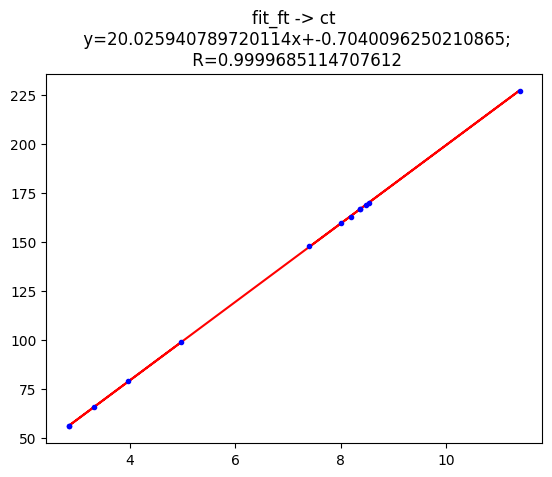

In [152]:
#fr = dataf['fr']+best[0]*dataf['gen_b']+best[1]*dataf['gen_s']
print("Both generators use .1 kg/s") # know from previous run
fr = dataf['fr']+.1*dataf['gen_b']+.1*dataf['gen_s']
dataf['fit_ft']=dataf['fuel']/fr
m,b,R = trendline(dataf,'fit_ft','ct')
print(f"Combat time ={m[0][0]} [ sum(fuel)]/[( sum(engines) + .1 # generators) ] + {b[0]}")

CT_FR_C = m[0][0]
CT_FR_B = b[0]

Range = 71.79589987235532 x Spd x Combat Time -373.16634268377675


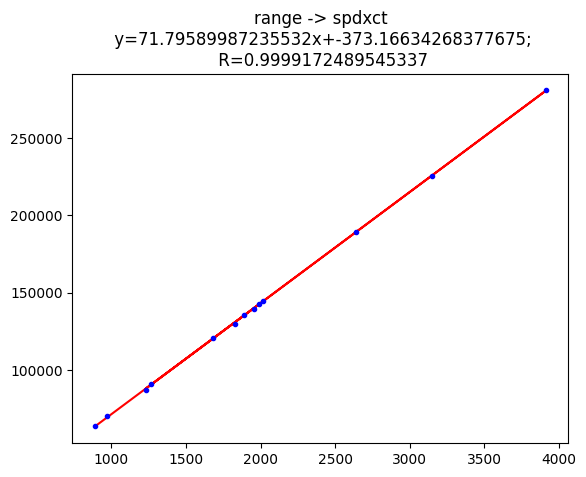

In [153]:
dataf['spdxct']=dataf['spd']*dataf['ct']
m,b,R = trendline(dataf,'range','spdxct')
print(f"Range = {m[0][0]} x Spd x Combat Time {b[0]}")

RANGE_SPD_CT_C = m[0][0]
RANGE_SPD_CT_B = b[0]

In [156]:
import json

prec = 6
json.dumps( {
    'SPD_TWR_C':round(SPD_TWR_C,prec),
    'SPD_TWR_B':round(SPD_TWR_B,prec),
    'CT_FR_C':round(CT_FR_C,prec),
    'CT_FR_B':round(CT_FR_B,prec),
    'RANGE_SPD_CT_C':round(RANGE_SPD_CT_C,6),
    'RANGE_SPD_BT_B':round(RANGE_SPD_CT_B,6)
})

'{"SPD_TWR_C": 9152.354478, "SPD_TWR_B": 0.258798, "CT_FR_C": 20.025941, "CT_FR_B": -0.70401, "RANGE_SPD_CT_C": 71.7959, "RANGE_SPD_BT_B": -373.166343}'

There you go. If you try to solve the actual constants by using unit analysis (e.g., thrust is MN, and weight is metric tons, etc), you'll go mad. There's fudge-factors in the game's calculations to make it more fun, where it departs somewhat from reality. 